In [22]:
import cv2
import numpy as np
from numpy.core.numeric import True_
from numpy.lib.arraysetops import unique
import pandas as pd
import glob
import os
import json
import datetime
import matplotlib.pyplot as plt


make_video = False
dataset_dir_path = './datasets/au-air/'

annotations_path = dataset_dir_path + 'auair2019annotations/'
image_path = dataset_dir_path + 'auair2019data/images/'
annotations_file = annotations_path + 'annotations.json'

video_ext = '.avi'
image_ext = '.jpg'
image_files = image_path + '*' + image_ext


In [23]:
def CollectingImages(cnt, remaining_cnt):
    print(f"Collecting {cnt} / {remaining_cnt} images...")
    img_array = []
    for i in range(cnt):
        img = cv2.imread(images.iloc[i])
        height, width, layers = img.shape
        image_size = (width, height)
        img_array.append(img)
        if((i % 200) == 0):
            print(str(round((i/cnt) * 100)) + ' %')

    return img_array, image_size

In [24]:

def CombineImages(img_array, video_name, fps, size):
    print("Combining images to: " + video_name)
    out = cv2.VideoWriter(
        video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    image_count = len(img_array)
    for i in range(image_count):
        out.write(img_array[i])
        if((i % 200) == 0):
            print(str(round((i/image_count) * 100)) + ' %')

    out.release()
    print("Created video: " + video_name)

In [25]:
def CreateVideo(images, fps, video_name, video_ext, video_frame_limit=3000):
    total_cnt = len(images)

    print(f"Found {total_cnt} images for this video recording.")
    image_count = total_cnt
    remaining_cnt = total_cnt
    video_idx = 0
    split_video = False
    while(remaining_cnt > 0):
        # limit size of videos
        if(remaining_cnt > video_frame_limit):
            image_count = video_frame_limit
            split_video = True
        else:
            image_count = remaining_cnt

        video_idx += 1
        img_array, img_size = CollectingImages(image_count, remaining_cnt)
        remaining_cnt -= max(image_count, 0)  # keep it positive

        if(split_video):
            full_video_name = video_name + '_' + str(video_idx) + video_ext
        else:
            full_video_name = video_name + video_ext

        if os.path.exists(full_video_name):
            os.remove(full_video_name)

        CombineImages(img_array, full_video_name, fps, img_size)

In [26]:
# def AddDateTime(names):
#     s = pd.Series(names.str.split('_'))
#     df_tmp = pd.DataFrame(s.tolist(), columns=['head', 'time', 'x', 'id.jpg'])
#     s = pd.Series(df_tmp['id.jpg'].str.split('.'))
#     df_tmp2 = pd.DataFrame(s.tolist(), columns=['id', 'jpg'])
#     df_full['time'] = df_tmp['time']
#     df_full['id'] = df_tmp2['id']
#     df_full.set_index('image_name')

## Creating annotations dataframe

In [27]:
# using annotations:
print("Loading annotations...")
data = json.load((open(annotations_file)))
df_json = pd.json_normalize(data, 'annotations').sort_values(by=['image_name'])
df_bbox = pd.json_normalize(
    data, ['annotations', 'bbox'])
print(len(df_json), len(df_bbox))
print(df_bbox)
print(
    f'Number for annotation duplicates is {df_json.image_name.duplicated().sum()}')


Loading annotations...
32823 132031
        top  left  height  width  class
0       163  1098     185    420      1
1       421  1128     176    393      1
2       927  1703     153    183      0
3       857   976      86    139      0
4        11   624     210    328      1
...     ...   ...     ...    ...    ...
132026  171   278      28     44      1
132027  104    34      34     31      1
132028  375   685      94    148      1
132029  345   451      91    155      1
132030   38     7     164    416      1

[132031 rows x 5 columns]
Number for annotation duplicates is 0


## Creating Image Dataframe

In [28]:


# df_json_date = df_json[df_json['image_name'].str.contains(search_date)]

# using images:
print("Finding image names...")
files = np.array(glob.glob(image_files))
df_imgs = pd.concat([pd.DataFrame([os.path.basename(file)], columns=['image_name']) for file in files],
                    ignore_index=True)
df_imgs['full_path'] = files
s = pd.Series(df_imgs['image_name'].str.split('_'))
df_tmp = pd.DataFrame(s.tolist(), columns=['head', 'short_name', 'x', 'id.jpg'])
s = pd.Series(df_tmp['id.jpg'].str.split('.'))
df_tmp2 = pd.DataFrame(s.tolist(), columns=['id', 'jpg'])
df_imgs['short_name'] = df_tmp['short_name']
df_imgs['id'] = df_tmp2['id']
df_imgs.set_index('image_name')
print(
    f'Number for image duplicates is {df_imgs.image_name.duplicated().sum()}')

# df_imgs = df_imgs.sort_values(by=['time', 'id']).drop_duplicates(
#     subset=['time', 'id'])
# year = df_json['time.year']
# month = df_json['time.month']
# day = df_json['time.day']
# min = df_json['time.min']
# sec = df_json['time.sec']
# msec = df_json['time.ms']
# print(year.values)
# df_json['datetime'] = pd.Timestamp(
#     str(year.values) + '-' + str(month.values) + '-' + str(day.values))
# # 'time.year', 'time.month', 'time.day', 'time.hour', 'time.min', 'time.sec')

# print(df_json['datetime'])


Finding image names...
Number for image duplicates is 0


## Merging dataframes

Date grouping: /n
time.year  time.month  time.day  time.hour  time.min  time.sec
2019       8           29        9          11        11          2592
           9           5         9          17        50          5734
                                 10         31        12          6840
                                 11         19        47           771
                                            25        22          5358
                                 14         21        19          2962
                                            35        5           1580
                       6         15         7         31          6986
dtype: int64


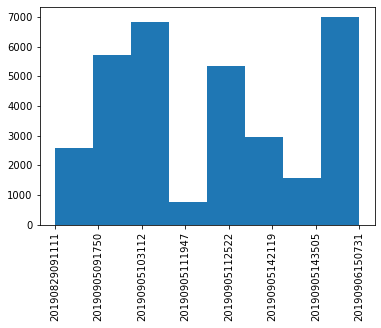

In [29]:
df_full = pd.merge(df_json, df_imgs, how='inner', on='image_name')
df_grp = df_full.groupby(
    by=['time.year', 'time.month', 'time.day', 'time.hour', 'time.min', 'time.sec'])
print("Date grouping: /n")
print(df_grp.size())


plt.hist(df_full['short_name'], bins=8)
plt.xticks(rotation = 90) 
plt.show()

## Finding number of recordings based on date

In [30]:
unique_dates = unique(df_full['short_name'])
recording_cnt = len(unique_dates)
print(f"There are {recording_cnt} video recordings:")
print(unique_dates)

There are 8 video recordings:
['20190829091111' '20190905091750' '20190905103112' '20190905111947'
 '20190905112522' '20190905142119' '20190905143505' '20190906150731']


## Set if to create a video in needed

In [31]:
#make_video = True

In [32]:
# do for loop here on date
cnt = recording_cnt
for i in range(0, cnt):
    search_date = unique_dates[i]
    print('####### START #########')
    print(f'Video # {i + 1} / {cnt}')
    print(f'Selecting date: {search_date}')
    df_recording = df_full[df_full['image_name'].str.contains(search_date)]
    images = pd.Series(df_recording['full_path'].values,
                       index=df_recording['full_path'])

# Calculate Frames Per Second
    timespan_ms = df_recording['time.ms'].iloc[-1] - \
        df_recording['time.ms'].iloc[0]
    timespan_sec = timespan_ms/1000
    print(
        f'Recording duration is {timespan_sec} sec')
    fps = len(df_recording)/timespan_sec
    print(f'fps: {fps}')

    if(make_video):
        video_name = 'video_' + search_date
        if os.path.exists(video_name + video_ext):
            os.remove(video_name + video_ext)

        CreateVideo(images, fps, video_name, video_ext, 2000)

    print('######## END ##########')


####### START #########
Video # 1 / 8
Selecting date: 20190829091111
Recording duration is 710.8 sec
fps: 3.6465953854811484
Found 2592 images for this video recording.
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Combining images to: video_20190829091111_1.avi
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Created video: video_20190829091111_1.avi
0 %
34 %
68 %
Combining images to: video_20190829091111_2.avi
0 %
34 %
68 %
Created video: video_20190829091111_2.avi
######## END ##########
